# COVID-19 situation in some highlighted countries
### Hung Dinh
### _April 19, 2020_

This notebook is created to fillfull the requirement for the last assignment, Data visualiation course in Data science specialization provided by the University of Michigan. Please note the final submitted figure is created at the end of the notebook as there are some discussion coming along the way.

Here are some quick information:

- **State the region:** Selected countries in the world, modified from the G7 country list
- **The domain category:** Health
- **Research question:** How different is the COVID-19 situation between these countries and what to expect?

- Two links to publicly accessible datasets:
    - List of G7 countries: https://en.wikipedia.org/wiki/Group_of_Seven
    - Covid-19 situation: https://www.worldometers.info/coronavirus/

## 1. Introduction

2020 starts with a global health pandemic: Coronavirus disease 2019 (COVID-19). The outbreak started at the end of 2019 from Wuhan (China) and quickly spread out all over the world. The coronavirus comes from the same family with previous 2020 SARS outbreak. I am interested in looking at the history of Covid-19 at some countries to compare and try to provide my personal predictions given the current data.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
# below is to discard datetime conversion warning from matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 2. Selected countries

At first, I focus on the most developed countries in the [G7 list](https://en.wikipedia.org/wiki/Group_of_Seven) (the seven largest advanced economy in the world): Canada, France, Germany, Italy, Japan, the United Kingdom and the United States. Of course they can be manually input to a python list, but I want to demonstrate the way we collect data from the internet, therefore some simple code is used for this purpose.

In addition, for Covid-19, some other countries should be included because they have their own special characteristics to discuss:
- China where the virus came from
- Iran: along with Italy being first outbreak in the Europe
- Singapore: example of special situation
- South-Korea: example of special situation

In [2]:
country = pd.read_html('https://en.wikipedia.org/wiki/Group_of_Seven')[3]['Member'][0:7]
country = country.tolist()
country

['Canada',
 'France',
 'Germany',
 'Italy',
 'Japan',
 'United Kingdom',
 'United States']

Add special countries:

In [3]:
country.extend(('China','Iran','Singapore','South-Korea'))

Rename some countries before scraping data from worldometer website:

In [4]:
country[country.index('United States')] = 'US'
country[country.index('United Kingdom')] = 'UK'

In [5]:
country

['Canada',
 'France',
 'Germany',
 'Italy',
 'Japan',
 'UK',
 'US',
 'China',
 'Iran',
 'Singapore',
 'South-Korea']

## 3. Data

Once the list of interested countries is obtained, Covid-19 history from each of them can be scraped from [worldometer](https://www.worldometers.info/coronavirus/) website. This is one of the best source which is reliable (it links to WHO and Johns Hopkins websites) and easy to access.

Define a function to collect data

In [6]:
def getcorona(country):
    # Scrape data
    results = requests.get('https://www.worldometers.info/coronavirus/country/'+country)
    soup = BeautifulSoup(results.text, "html.parser")
    a = soup.find_all('div', class_='row graph_row')
    
    # Extract date
    b = a[0].script.text
    date = pd.DataFrame(b[b.find('[', b.find('categories:'))+1:b.find(']', b.find('categories: ['))].replace('"','').split(','))
    # Extract total case
    b = a[0].script.text
    total_case = pd.DataFrame(b[b.find('[', b.find('data:'))+1:b.find(']', b.find('data: ['))].split(','))
    # Extract daily new case
    b = a[1].script.text
    daily_new_case = pd.DataFrame(b[b.find('[', b.find('data:'))+1:b.find(']', b.find('data: ['))].split(','))
    # Extract total death
    b = a[3].script.text
    total_death = pd.DataFrame(b[b.find('[', b.find('data:'))+1:b.find(']', b.find('data: ['))].split(','))
    # Extract daily new death
    b = a[4].script.text
    daily_new_death = pd.DataFrame(b[b.find('[', b.find('data:'))+1:b.find(']', b.find('data: ['))].split(','))
    
    # Then merge all data
    dat = date
    dat['Country'] = country    
    dat = pd.concat([dat,total_case,daily_new_case,total_death,daily_new_death], axis=1)
    dat.columns=['Date','Country','TotalCase','DailyNewCase','TotalDeath','DailyNewDeath']
#     dat.replace('null','0', inplace=True)
    dat.Date = dat.Date+' 2020'
    dat['Date'] = pd.to_datetime(dat['Date'])
    col=['TotalCase','DailyNewCase','TotalDeath','DailyNewDeath']
    dat[col] = dat[col].apply(pd.to_numeric, errors='coerce', axis=1)
    
    return dat

Now collect the data for each interested country

In [7]:
df = pd.DataFrame()
for nation in country:
#     print(nation)
    df = df.append(getcorona(nation))
df.reset_index(drop=True,inplace=True)

In [8]:
df.tail()

,Date,Country,TotalCase,DailyNewCase,TotalDeath,DailyNewDeath
734,2020-04-15,South-Korea,10591.0,27.0,225.0,3.0
735,2020-04-16,South-Korea,10613.0,22.0,229.0,4.0
736,2020-04-17,South-Korea,10635.0,22.0,230.0,1.0
737,2020-04-18,South-Korea,10653.0,18.0,232.0,2.0
738,2020-04-19,South-Korea,10661.0,8.0,234.0,2.0


In [9]:
'''
Please note that whenever the script is run, it fetches latest data from worldometer.
Because I wrote this notebook on April 18, 2020, data updated after this date is discarded for repeatability.
If newer data is needed for study, this step can be ignored:
'''
df = df[df['Date']<='2020-04-18']

## 4. Exploratory analysis

Let's first make a plot of the Total case

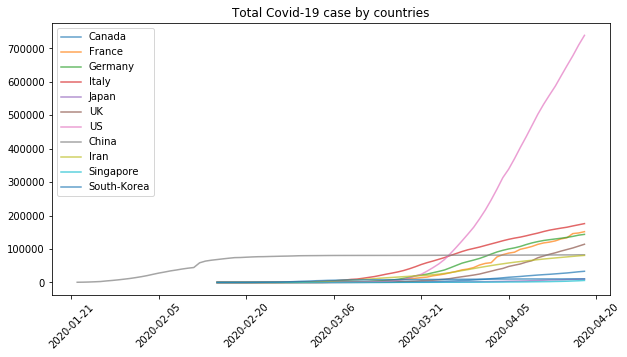

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

for i in country:
    dfplot5 = df[df['Country']==i]
    dfplot5.set_index('Date', inplace=True)
    ax.plot(dfplot5.index, dfplot5['TotalCase'], alpha=0.7)

plt.legend(country)
plt.title('Total Covid-19 case by countries')
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))

Here we can see a linear axis is not ideal for our comparison purpose. Let's do it again in logarithm scale:

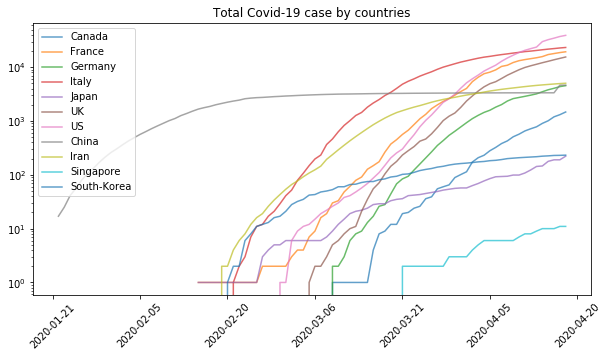

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

for i in country:
    dfplot5 = df[df['Country']==i]
    dfplot5.set_index('Date', inplace=True)
    ax.plot(dfplot5.index, dfplot5['TotalDeath'], alpha=0.7)

plt.legend(country)
plt.title('Total Covid-19 case by countries')

plt.xticks(rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.yscale('log')

Now the data is more comparable. However because the desease started at different time in each country. It's better to move them to a same reference. Here I replot them, horizontal axis by the number of day after the 100th case detected.

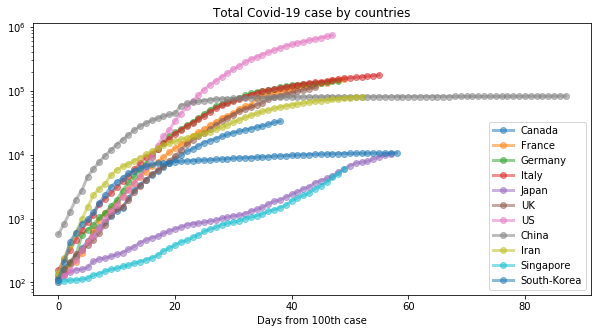

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

for i in country:
#     dfplot5 = df[df['Country']==i]
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)

#     dfplot5.set_index('Date', inplace=True)
    ax.plot(dfplot5.index, dfplot5['TotalCase'], marker='o', linewidth=3, alpha=0.5)

plt.legend(country)
plt.title('Total Covid-19 case by countries')

plt.xlabel('Days from 100th case')
# plt.xticks(rotation=45)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.yscale('log')

Here we can see a very similar trend is found between France (orange curve) and UK (brown curve). Another similar trend is also found between Germany (green curve) and Italy (red curve). This is understandable because these countries are members of the EU group with no transport restriction and with very similar health care system. To make future plots cleaner, we can eliminate a pair of them from the data.

In [13]:
country = np.delete(country,[1, 2])

In [14]:
df1 = df[(df['Country']!='France')&(df['Country']!='Germany')]

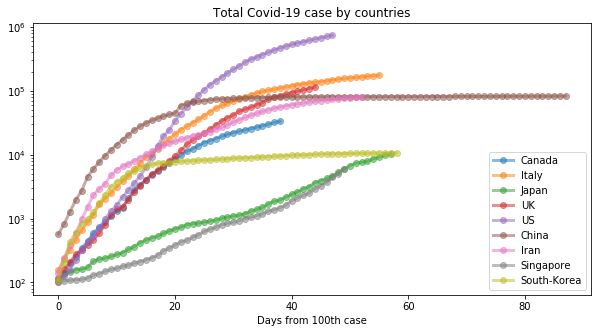

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

for i in country:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    ax.plot(dfplot5.index, dfplot5['TotalCase'], marker='o', linewidth=3, alpha=0.5)

plt.legend(country)
plt.title('Total Covid-19 case by countries')
# ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.xlabel('Days from 100th case')
plt.yscale('log')

Now the plot is much clearer for analysis. Now let's look at some specific trends:

- China and South Korea
- Italy and Iran
- UK vs. rest of Europe
- Singapore and Japan
- US, UK and Canada
- Main economic zones: US, UK, EU, China

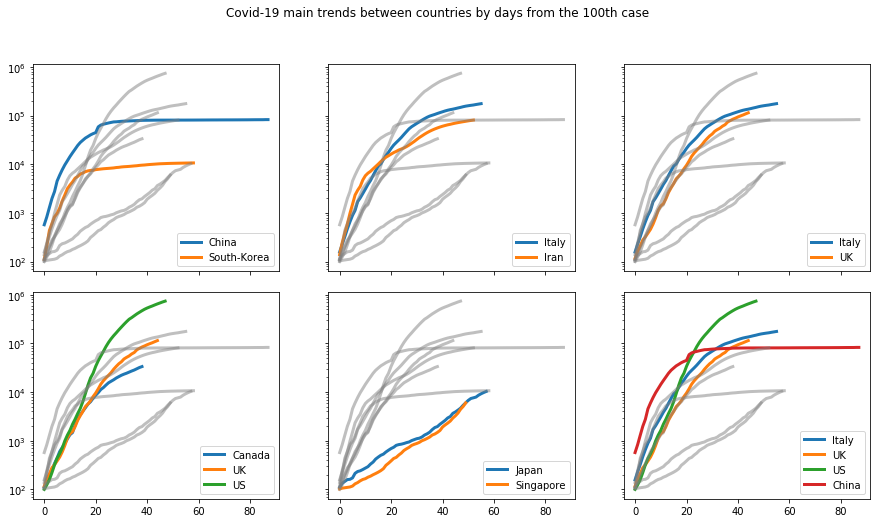

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 8))

for i in country[[5,8]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[0, 0].plot(dfplot5.index, dfplot5['TotalCase'], linewidth=3)
for i in country[[0,1,2,3,4,6,7]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[0, 0].plot(dfplot5.index, dfplot5['TotalCase'], color='gray', linewidth=3, alpha=0.5)
    axes[0, 0].legend(country[[5,8]], loc = 4)

for i in country[[1,6]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[0, 1].plot(dfplot5.index, dfplot5['TotalCase'], linewidth=3)
for i in country[[0,2,3,4,5,7,8]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[0, 1].plot(dfplot5.index, dfplot5['TotalCase'], color='gray', linewidth=3, alpha=0.5)
    axes[0, 1].legend(country[[1,6]], loc = 4)
    
for i in country[[1,3]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[0, 2].plot(dfplot5.index, dfplot5['TotalCase'], linewidth=3)
for i in country[[0,2,4,5,6,7,8]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[0, 2].plot(dfplot5.index, dfplot5['TotalCase'], color='gray', linewidth=3, alpha=0.5)
    axes[0, 2].legend(country[[1,3]], loc = 4)

for i in country[[0,3,4]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[1, 0].plot(dfplot5.index, dfplot5['TotalCase'], linewidth=3)    
for i in country[[1,2,5,6,7,8]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[1, 0].plot(dfplot5.index, dfplot5['TotalCase'], color='gray', linewidth=3, alpha=0.5)
    axes[1, 0].legend(country[[0,3,4]], loc = 4)
    
for i in country[[2,7]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[1, 1].plot(dfplot5.index, dfplot5['TotalCase'], linewidth=3)
for i in country[[0,1,3,4,5,6,8]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[1, 1].plot(dfplot5.index, dfplot5['TotalCase'], color='gray', linewidth=3, alpha=0.5)
    axes[1, 1].legend(country[[2,7]], loc = 4)
    
for i in country[[1,3,4,5]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[1, 2].plot(dfplot5.index, dfplot5['TotalCase'], linewidth=3)
for i in country[[0,2,6,7,8]]:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    axes[1, 2].plot(dfplot5.index, dfplot5['TotalCase'], color='gray', linewidth=3, alpha=0.5)
    axes[1, 2].legend(country[[1,3,4,5]], loc = 4)


fig.suptitle("Covid-19 main trends between countries by days from the 100th case")

# for ax in axes.flat:
#     ax.set(xlabel='Days from 100th case', yscale='log')

for ax in axes.flat:
    ax.set(yscale='log')

plt.subplots_adjust(hspace=0.1)

plt.show()

## 5. Discussion

There are some interesting finding from 6 plots above:

- **China and South Korea (top left)**: These two countries have controled the outbreak very well. Although South Korea had the 100th case about 1 month after China, both of them have almost no new case after 30 days. The desease has passed the peak and total case curve becomes flat.


- **Italy and Iran (top middle)**: These two countries (along with South Korea) are the new outbreak in the global scale, started in the third week of February. Different from South Korea, the new case just blew them up with very steep accumulation curves. We can see Iran increase a bit faster at the beginning. After 3 weeks, it slowed down. On the other hand, Italy passed Iran in the new cases around 30 days and passed China about 45 days after the 100th case. At this moment both countries have passed the peak as total case seems to slow down. If everything goes similar to China and South Korea, it would take about another 30 days for Iran and Italy to reach the flat curve.


- **Italy and UK (top right)**: Note that UK and France are similar, while Italy and Germany are similar. From other sources, it is also shown that other Central Europian countries (ie. Spain, Belgium, Netherlands, Switzerland, Portugal, Austria) are also similar to Germany. We can hereby see the difference between UK (and France) to the rest of Central Europe. Although the Covid-19 development in the UK is not as bad as Italy at the beginning, because of late lockdown announcement, it is likely to become the worst affected country in Europe and will be passing Italy within a week. A good sign is the increase seems to start slowing down.


- **Canada, US and UK (lower left)**: The historical close interconnection between these 3 countries seems to be presented at the early stage of the outbreak. After about 2 weeks since the first 100th case, the desease spread out quickly in the US, and for another week, Canada starts to slow down departing from the UK. At the moment, the 3 countries still seem to stay at a similar situation. Fortunately there are signs that they have just passed the peak. However it may be still too early, especially for the US, to tell when they would reach the flat curve.


- **Japan and Singapore (lower middle)**: From the original plot, we see Japan's first case is 1 month after China, and followed by another month from Singapore. The curves indicate these 2 countries are extremely effectively controled the outbreak. In fact, it no longer even looked like a outbreak after 30 days since their 100th case. However because these countries lifted the restriction too early, the situation quickly got worse. Singapore is now having high increase of the case and have already catched up with Japan and will pass South Korea Within a week. Japan will pass South Korea in a matter of days. _Please note that this log scale does not fully imply how bad the coronavirus scenario in each country based on the positive case (recall linear plot, Singapore currently has relatively low number of case compared to other countries). The log scale instead focuses on the rate of the case._


- **Main economic zones: US, UK, EU, China (lower right)**: Here I assume Italy conservatively represents the main trend within Europe. This plot therefore gives us a quick look of the situation at four main international economic zones. Apparently China had the desease at the earliest but it is fully under controled now. In the other three which now have passed China in the number of case, the Europe has highest rate at the beginning, but now seems to get over the peak time. Both UK and US had later restriction actions and now still have high rate increasing. The US has passed Italy after 2.5 weeks since the 100th case. UK has lower increase rate than US after 2 weeks and will also pass Italy within a week. Since WHO recommended not to lift restriction too early, the economy is likely to be back to normal firstly from China, then Europe, UK and finally US.

## 6. Conclusion

For a take-away message, I recreate the full look at all selected countries as shown below.

This visual investigation provides a quick overview on the Covid-19 development history at selected countries. The adaptive display (log scale with days from the 100th case) gives us a better comparison between them. By considering a flat curve as a sign of desease peak, some main trends have been detected: approach the peak, be at the peak or overcome the peak. The difference in increasing rate between countries can also be observed. Using this data, I have drawn some prediction on a possible scenario for each country.

To address visualization standards, here are some notes:
- **Truthfulness**: The number of total cases is kept as is (if one uses Daily new case or Daily new death, a smoothing needs to be applied).
- **Functionality**: Plotting data in 30s of days after 100th case (x) and log scale (y) provides better reference for comparison.
- **Beauty**: The graph employes bright colors, large font size and removal of unneccesary borders.
- **Insightfulness**: The plot reveals development rate of the virus between countries. Annotations with arrows are provided to highlight trends.

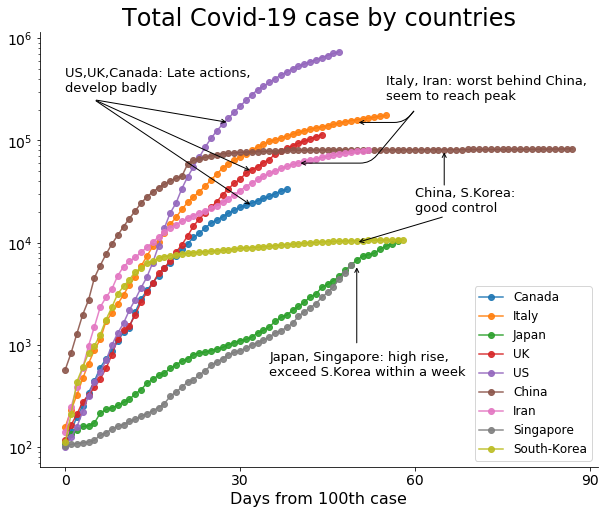

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
# Plot data
for i in country:
    dfplot5 = df[(df['TotalCase']>=100) & (df['Country']==i)]
    dfplot5.reset_index(inplace=True)
    ax.plot(dfplot5.index, dfplot5['TotalCase'], marker='o', linestyle='-', alpha=0.9)  
# Annotation 1
ax.annotate("", xy=(50, 6000),  xycoords='data',
            xytext=(50, 1000), textcoords='data',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("Japan, Singapore: high rise,\nexceed S.Korea within a week",
            xy=(35, 500), size=13, xycoords='data') 
# Annotation 2
ax.annotate("", xy=(65, 80000),  xycoords='data',
            xytext=(65, 35000), textcoords='data',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(50, 10000),  xycoords='data',
            xytext=(65, 18000), textcoords='data',
            arrowprops=dict(arrowstyle="->")) 
ax.annotate("China, S.Korea:\ngood control", xy=(60, 20000), size=13, xycoords='data') 
# Annotation 3
ax.annotate("", xy=(28, 150000),  xycoords='data',
            xytext=(5, 250000), textcoords='data',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(32, 50000),  xycoords='data',
            xytext=(5, 250000), textcoords='data',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(32, 23000),  xycoords='data',
            xytext=(5, 250000), textcoords='data',
            arrowprops=dict(arrowstyle="->"))
ax.annotate("US,UK,Canada: Late actions,\ndevelop badly", xy=(0, 300000), size=13, xycoords='data')
# Annotation 4
ax.annotate('', xy=(40, 60000),  xycoords='data',
            xytext=(60, 200000), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=-130,angleB=0,rad=10"))
ax.annotate('', xy=(50, 150000),  xycoords='data',
            xytext=(60, 200000), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=-130,angleB=0,rad=10"))
ax.annotate("Italy, Iran: worst behind China,\nseem to reach peak", xy=(55, 250000), size=13, xycoords='data')
# Other cosmetic settings
plt.title('Total Covid-19 case by countries', fontsize=24)
plt.xlabel('Days from 100th case', fontsize=16)
plt.legend(country, loc=4, prop={'size': 12})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks([0,30,60,90])
plt.yscale('log')